<a href="https://colab.research.google.com/github/san9roy/Environment-And-Climate/blob/main/Environment_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4042181186.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_monthly = weather_df[temp_col].resample("M").mean()
/tmp/ipython-input-4042181186.py:54: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  temp_yearly = weather_df[temp_col].resample("Y").mean()


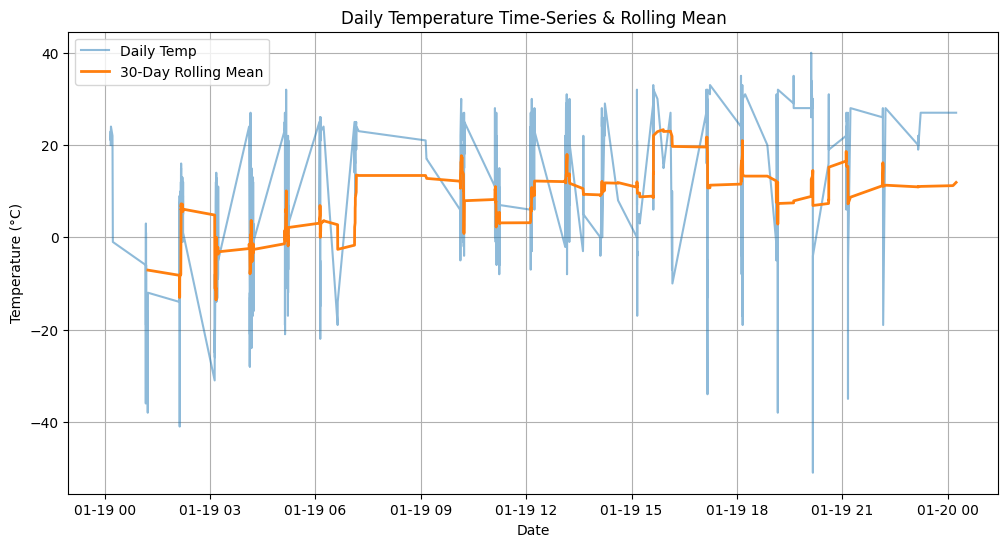

<Figure size 1200x600 with 0 Axes>

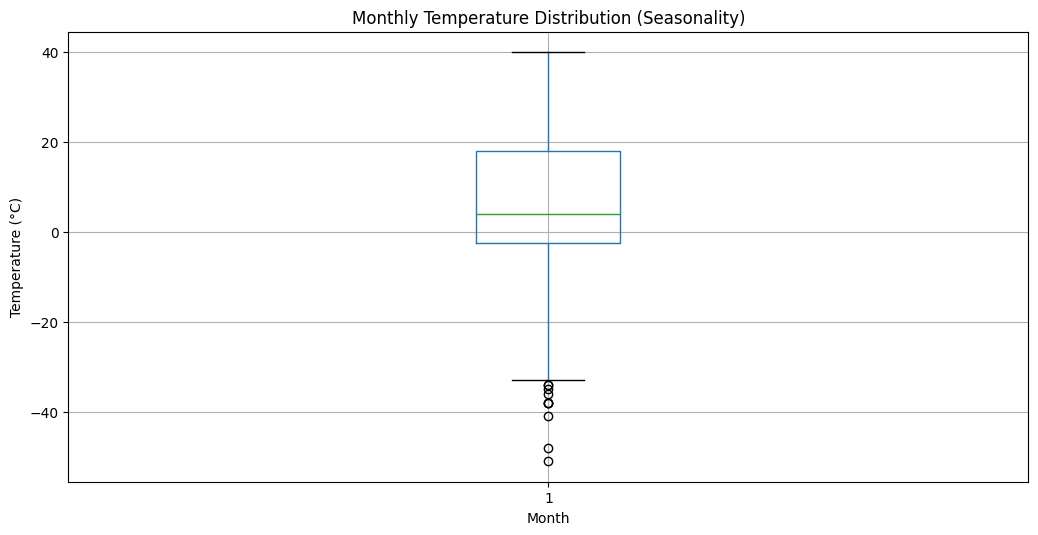

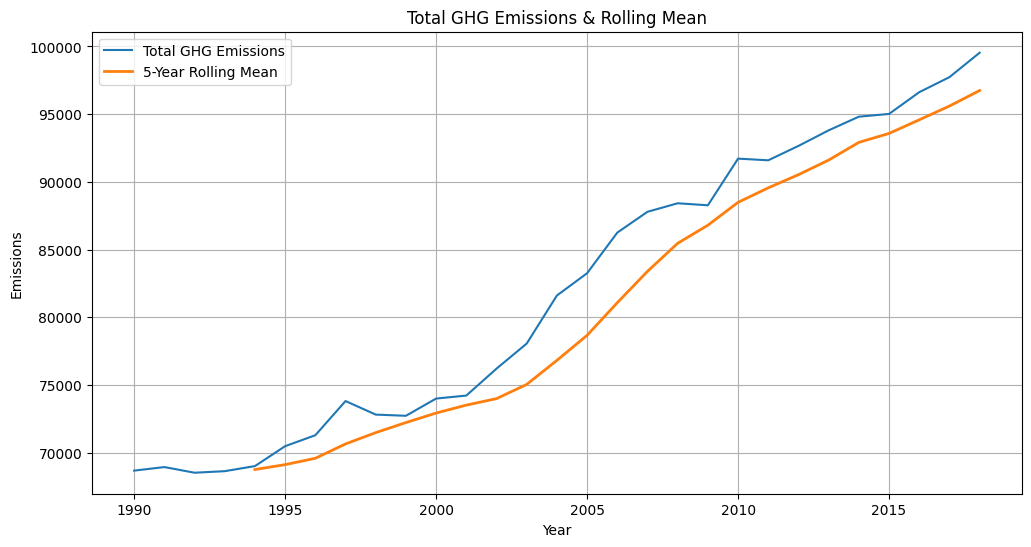

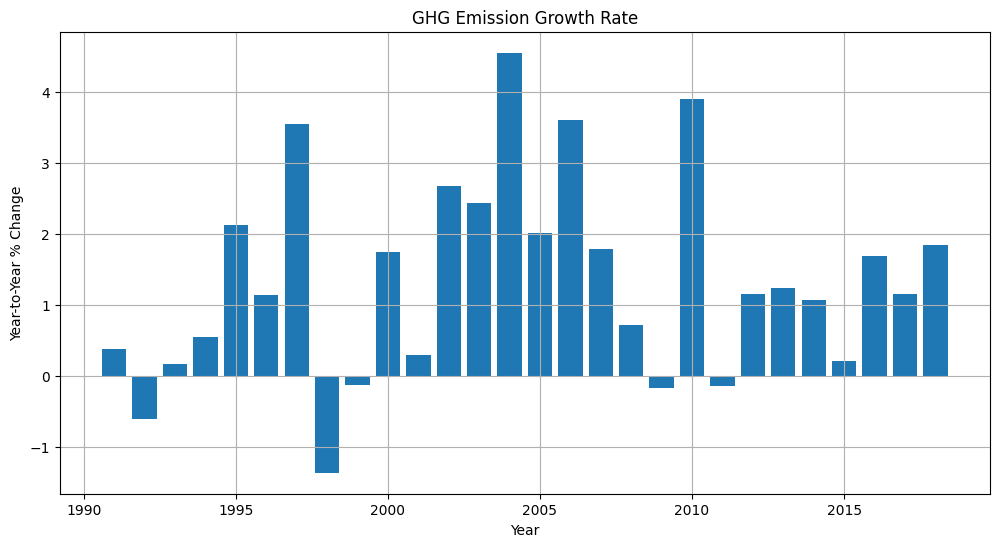

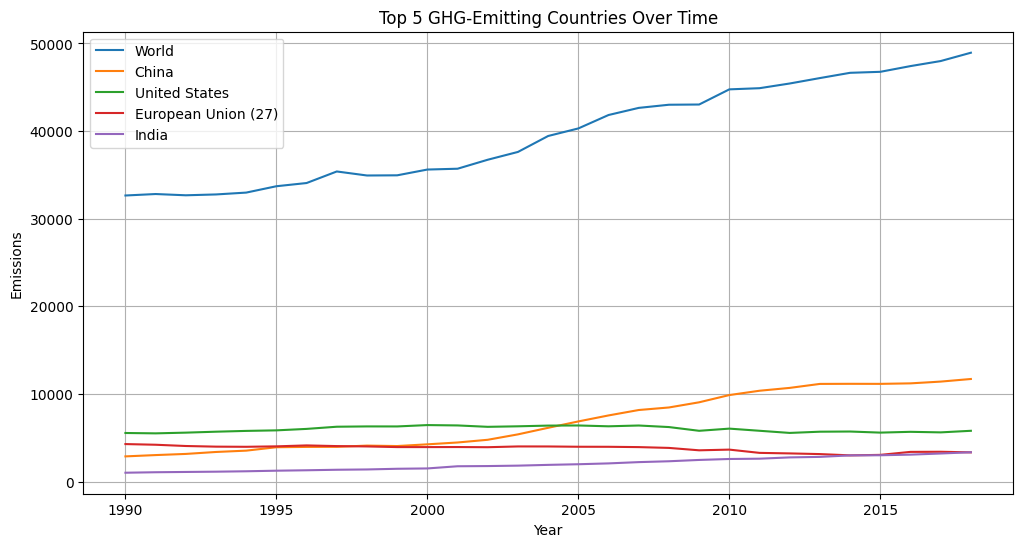

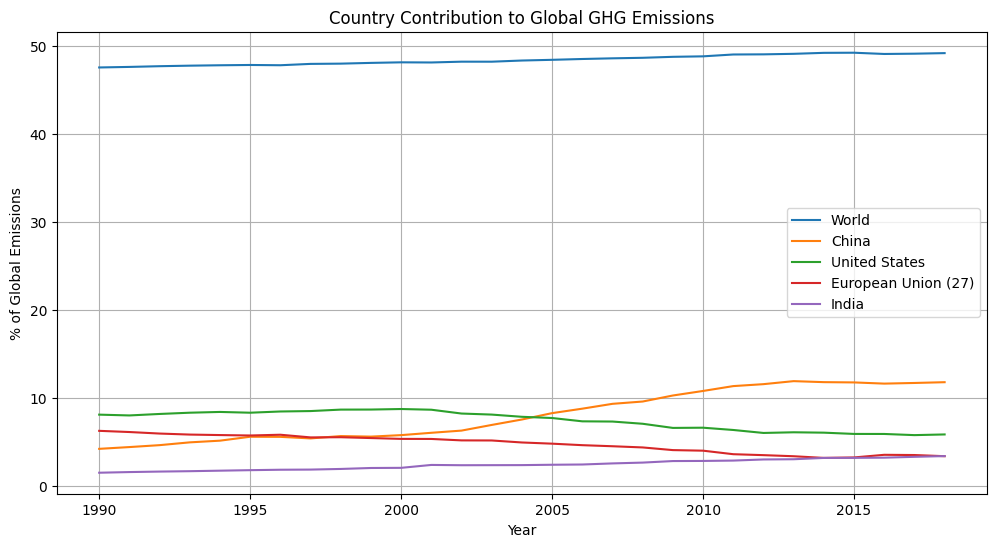

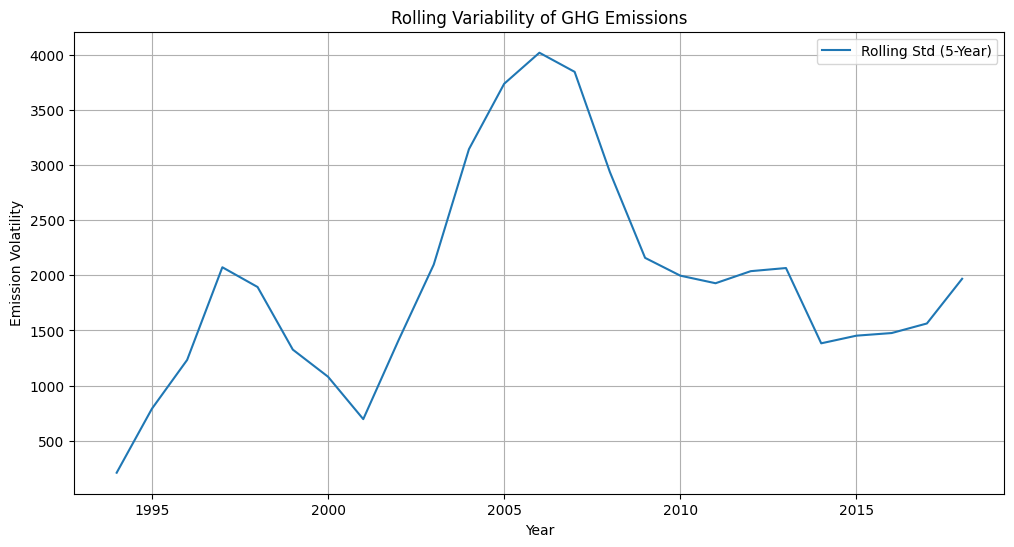

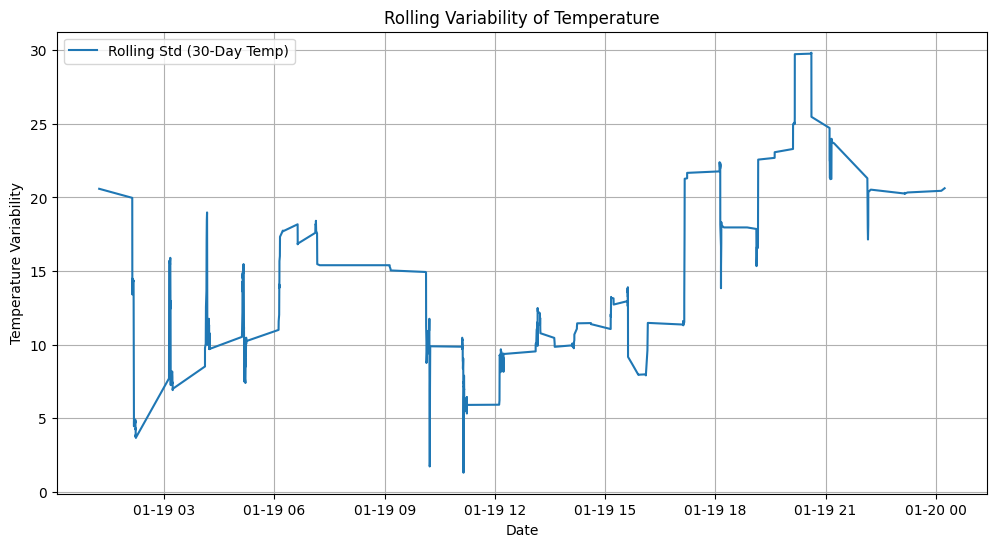


--- Temperature Statistics ---
count    983.000000
mean       5.587996
std       14.986625
min      -51.000000
25%       -2.500000
50%        4.000000
75%       18.000000
max       40.000000
Name: temparature, dtype: float64

--- GHG Global Statistics ---
count       29.000000
mean     81943.488621
std      10709.531163
min      68516.540000
25%      72721.440000
50%      81603.550000
75%      91711.770000
max      99533.690000
Name: Emissions, dtype: float64

All analyses completed successfully.


In [13]:
# =========================================================
# Environmental Time-Series Analysis of Temperature & GHG Emissions
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (12, 6)

# ---------------------------------------------------------
# LOAD DATASETS
# ---------------------------------------------------------

weather_df = pd.read_csv("weather_dataset_19-01-2020.csv")
ghg_df = pd.read_csv("ALL GHG_historical_emissions.csv")

# ---------------------------------------------------------
# TEMPERATURE DATA PROCESSING
# ---------------------------------------------------------

# Detect date column
date_col = next((c for c in weather_df.columns if "date" in c.lower() or "time" in c.lower()), None)
if date_col is None:
    raise ValueError("No date/time column found in weather dataset.")

weather_df[date_col] = pd.to_datetime(weather_df[date_col], errors="coerce")
weather_df = weather_df.dropna(subset=[date_col]).sort_values(date_col)
weather_df.set_index(date_col, inplace=True)

# Detect temperature column
temp_col = next((c for c in weather_df.columns if "temp" in c.lower()), None)
if temp_col is None:
    raise ValueError("No temperature column found in weather dataset.")

# Clean temperature values
weather_df[temp_col] = (
    weather_df[temp_col].astype(str)
    .str.replace(",", ".", regex=False)
    .str.replace(r"[^\d\.\-]", "", regex=True)
)
weather_df[temp_col] = pd.to_numeric(weather_df[temp_col], errors="coerce")
weather_df = weather_df.dropna(subset=[temp_col])
weather_df = weather_df[~weather_df.index.duplicated()]

# Daily rolling mean & std
weather_df["rolling_mean_30"] = weather_df[temp_col].rolling(30).mean()
weather_df["rolling_std_30"] = weather_df[temp_col].rolling(30).std()

# Monthly and yearly aggregation
temp_monthly = weather_df[temp_col].resample("M").mean()
temp_yearly = weather_df[temp_col].resample("Y").mean()
temp_yearly.index = temp_yearly.index.year
temp_monthly.index = temp_monthly.index.to_period("M")

# ---------------------------------------------------------
# TEMPERATURE VISUALIZATION & SEASONALITY
# ---------------------------------------------------------

# Daily temperature trend with rolling mean
plt.figure()
plt.plot(weather_df.index, weather_df[temp_col], alpha=0.5, label="Daily Temp")
plt.plot(weather_df.index, weather_df["rolling_mean_30"], linewidth=2, label="30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daily Temperature Time-Series & Rolling Mean")
plt.legend()
plt.grid(True)
plt.show()

# Monthly temperature boxplot for seasonality
weather_df["Month"] = weather_df.index.month
plt.figure()
weather_df.boxplot(column=temp_col, by="Month")
plt.title("Monthly Temperature Distribution (Seasonality)")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# GHG DATA PROCESSING
# ---------------------------------------------------------

ghg_df.columns = ghg_df.columns.str.strip()
year_cols = [c for c in ghg_df.columns if c.isdigit()]
id_vars = [c for c in ghg_df.columns if c not in year_cols]

ghg_long = ghg_df.melt(
    id_vars=id_vars,
    value_vars=year_cols,
    var_name="Year",
    value_name="Emissions"
)
ghg_long["Year"] = ghg_long["Year"].astype(int)
ghg_long["Emissions"] = pd.to_numeric(ghg_long["Emissions"], errors="coerce")
ghg_long = ghg_long.dropna(subset=["Emissions"])

# Global totals
ghg_global = ghg_long.groupby("Year", as_index=False)["Emissions"].sum().sort_values("Year")
ghg_global.set_index("Year", inplace=True)

# Rolling mean & std for variability
ghg_global["rolling_mean_5"] = ghg_global["Emissions"].rolling(5).mean()
ghg_global["rolling_std_5"] = ghg_global["Emissions"].rolling(5).std()

# ---------------------------------------------------------
# GHG VISUALIZATION
# ---------------------------------------------------------

plt.figure()
plt.plot(ghg_global.index, ghg_global["Emissions"], label="Total GHG Emissions")
plt.plot(ghg_global.index, ghg_global["rolling_mean_5"], linewidth=2, label="5-Year Rolling Mean")
plt.xlabel("Year")
plt.ylabel("Emissions")
plt.title("Total GHG Emissions & Rolling Mean")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# EMISSION GROWTH RATE
# ---------------------------------------------------------

ghg_global["YoY_change_%"] = ghg_global["Emissions"].pct_change() * 100

plt.figure()
plt.bar(ghg_global.index, ghg_global["YoY_change_%"])
plt.xlabel("Year")
plt.ylabel("Year-to-Year % Change")
plt.title("GHG Emission Growth Rate")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# COUNTRY-LEVEL EMISSION COMPARISON
# ---------------------------------------------------------

if "Country" in ghg_long.columns:
    top_countries = ghg_long.groupby("Country")["Emissions"].sum().sort_values(ascending=False).head(5).index
    plt.figure()
    for country in top_countries:
        country_data = ghg_long[ghg_long["Country"] == country].groupby("Year")["Emissions"].sum()
        plt.plot(country_data.index, country_data.values, label=country)
    plt.xlabel("Year")
    plt.ylabel("Emissions")
    plt.title("Top 5 GHG-Emitting Countries Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------
# CONTRIBUTION ANALYSIS (Country % of Global)
# ---------------------------------------------------------

if "Country" in ghg_long.columns:
    # Use transform to align
    ghg_long["GlobalShare_%"] = ghg_long.groupby("Year")["Emissions"].transform(lambda x: 100 * x / x.sum())

    plt.figure()
    for country in top_countries:
        country_share = ghg_long[ghg_long["Country"] == country].groupby("Year")["GlobalShare_%"].sum()
        plt.plot(country_share.index, country_share.values, label=country)
    plt.xlabel("Year")
    plt.ylabel("% of Global Emissions")
    plt.title("Country Contribution to Global GHG Emissions")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------
# ROLLING VARIABILITY
# ---------------------------------------------------------

plt.figure()
plt.plot(ghg_global.index, ghg_global["rolling_std_5"], label="Rolling Std (5-Year)")
plt.xlabel("Year")
plt.ylabel("Emission Volatility")
plt.title("Rolling Variability of GHG Emissions")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(weather_df.index, weather_df["rolling_std_30"], label="Rolling Std (30-Day Temp)")
plt.xlabel("Date")
plt.ylabel("Temperature Variability")
plt.title("Rolling Variability of Temperature")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# STATISTICAL DESCRIPTIVES
# ---------------------------------------------------------

print("\n--- Temperature Statistics ---")
print(weather_df[temp_col].describe())

print("\n--- GHG Global Statistics ---")
print(ghg_global["Emissions"].describe())

print("\nAll analyses completed successfully.")
